# 1. Read Tox21 from MoleculeNet dataset

In [71]:
from torch_geometric.datasets import MoleculeNet
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import matplotlib.pyplot as plt
import py3Dmol

# Load MoleculeNet dataset
dataset = MoleculeNet(root="data/MoleculeNet", name="Tox21")

# Extract the SMILES strings from the dataset (Tox21 contains SMILES in `smiles` attribute)
smiles_list = dataset.data.smiles  # SMILES strings are typically in this field

# Process the first molecule
example_index = 1
smiles = smiles_list[example_index]
print(f"SMILES String: {smiles}")

# Convert SMILES to RDKit molecule
mol = Chem.MolFromSmiles(smiles)


SMILES String: CCN1C(=O)NC(c2ccccc2)C1=O


# 1. 2D/3D Visualization

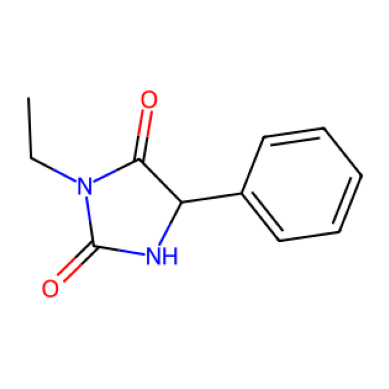

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [72]:
# Generate 2D Coordinates
AllChem.Compute2DCoords(mol)

# Visualize as a 2D Molecule
img = Draw.MolToImage(mol, size=(300, 300))
plt.imshow(img)
plt.axis('off')
plt.show()

# Generate 3D Coordinates
mol_3d = Chem.AddHs(mol)  # Add hydrogens for 3D structure
AllChem.EmbedMolecule(mol_3d, AllChem.ETKDG())  # Generate 3D conformation

# Visualize as a 3D Molecule using py3Dmol
block = Chem.MolToMolBlock(mol_3d)
view = py3Dmol.view(width=400, height=400)
view.addModel(block, "mol")  # Add the molecule
view.setStyle({"stick": {}})  # Style as sticks
view.zoomTo()  # Zoom to fit
view.show()

# 3. GCN classification task

## 3.1. Analysis dataset

In [73]:
# Import required libraries
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score

# Load MoleculeNet dataset (Tox21)
dataset = MoleculeNet(root="data/MoleculeNet", name="Tox21")
print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_node_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: Tox21(7831)
Number of graphs: 7831
Number of features: 9
Number of classes: 12


## 3.2. Split train/validation/test sets

In [74]:
# Split dataset into train, validation, and test sets
torch.manual_seed(42)
train_dataset = dataset[:int(len(dataset) * 0.8)]
val_dataset = dataset[int(len(dataset) * 0.8):int(len(dataset) * 0.9)]
test_dataset = dataset[int(len(dataset) * 0.9):]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 3.3. GCN 

In [75]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        
        # Input layer
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))
        
        # Output layer
        self.fc = Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)
    
    def forward(self, x, edge_index, batch):
        # Apply GCN layers
        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = conv(x, edge_index)
            x = batch_norm(x)
            x = F.relu(x)
            x = self.dropout(x)
        
        # Global pooling
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

## 3.4. Train, Evaluation function

In [76]:
# Initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=dataset.num_classes,
    num_layers=3,
    dropout=0.5
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        data.x = data.x.float()
        data.y = data.y.float()
        
        # Mask valid labels (non-NaN)
        mask = ~torch.isnan(data.y)
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out[mask], data.y[mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            data.x = data.x.float()
            data.y = data.y.float()
            
            # Mask valid labels (non-NaN)
            mask = ~torch.isnan(data.y)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out[mask], data.y[mask])
            total_loss += loss.item()
            
            y_true.append(data.y[mask].cpu())
            y_pred.append(out[mask].cpu())
    
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    
    # Compute ROC-AUC
    roc_auc = roc_auc_score(y_true.numpy(), y_pred.sigmoid().numpy(), average="macro")
    return total_loss / len(loader), roc_auc

# Training loop
for epoch in range(1, 31):
    train_loss = train()
    val_loss, val_roc_auc = evaluate(val_loader)
    print(f"Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

# Test the model
test_loss, test_roc_auc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")

Epoch: 01, Train Loss: 0.3318, Val Loss: 0.2356, Val ROC-AUC: 0.7463
Epoch: 02, Train Loss: 0.2378, Val Loss: 0.2284, Val ROC-AUC: 0.7548
Epoch: 03, Train Loss: 0.2331, Val Loss: 0.2217, Val ROC-AUC: 0.7657
Epoch: 04, Train Loss: 0.2310, Val Loss: 0.2239, Val ROC-AUC: 0.7650
Epoch: 05, Train Loss: 0.2279, Val Loss: 0.2243, Val ROC-AUC: 0.7608
Epoch: 06, Train Loss: 0.2272, Val Loss: 0.2207, Val ROC-AUC: 0.7725
Epoch: 07, Train Loss: 0.2265, Val Loss: 0.2200, Val ROC-AUC: 0.7702
Epoch: 08, Train Loss: 0.2251, Val Loss: 0.2168, Val ROC-AUC: 0.7816
Epoch: 09, Train Loss: 0.2252, Val Loss: 0.2202, Val ROC-AUC: 0.7726
Epoch: 10, Train Loss: 0.2231, Val Loss: 0.2170, Val ROC-AUC: 0.7804
Epoch: 11, Train Loss: 0.2226, Val Loss: 0.2173, Val ROC-AUC: 0.7799
Epoch: 12, Train Loss: 0.2216, Val Loss: 0.2187, Val ROC-AUC: 0.7790
Epoch: 13, Train Loss: 0.2208, Val Loss: 0.2178, Val ROC-AUC: 0.7804
Epoch: 14, Train Loss: 0.2213, Val Loss: 0.2163, Val ROC-AUC: 0.7854
Epoch: 15, Train Loss: 0.2224, Val

## 4. GraphSAGE

In [54]:
# Import required libraries
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score

# Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5):
        super(GraphSAGE, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        
        # Input layer
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))
        
        # Output layer
        self.fc = Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)
    
    def forward(self, x, edge_index, batch):
        # Apply GraphSAGE layers
        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = conv(x, edge_index)
            x = batch_norm(x)
            x = F.relu(x)
            x = self.dropout(x)
        
        # Global pooling
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

In [55]:
# Initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphSAGE(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=dataset.num_classes,
    num_layers=3,
    dropout=0.5
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        data.x = data.x.float()
        data.y = data.y.float()
        
        # Mask valid labels (non-NaN)
        mask = ~torch.isnan(data.y)
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out[mask], data.y[mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            data.x = data.x.float()
            data.y = data.y.float()
            
            # Mask valid labels (non-NaN)
            mask = ~torch.isnan(data.y)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out[mask], data.y[mask])
            total_loss += loss.item()
            
            y_true.append(data.y[mask].cpu())
            y_pred.append(out[mask].cpu())
    
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    
    # Compute ROC-AUC
    roc_auc = roc_auc_score(y_true.numpy(), y_pred.sigmoid().numpy(), average="macro")
    return total_loss / len(loader), roc_auc

# Training loop
for epoch in range(1, 31):
    train_loss = train()
    val_loss, val_roc_auc = evaluate(val_loader)
    print(f"Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

# Test the model
test_loss, test_roc_auc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")

Epoch: 01, Train Loss: 0.3350, Val Loss: 0.2347, Val ROC-AUC: 0.7308
Epoch: 02, Train Loss: 0.2358, Val Loss: 0.2268, Val ROC-AUC: 0.7502
Epoch: 03, Train Loss: 0.2326, Val Loss: 0.2260, Val ROC-AUC: 0.7506
Epoch: 04, Train Loss: 0.2296, Val Loss: 0.2207, Val ROC-AUC: 0.7695
Epoch: 05, Train Loss: 0.2279, Val Loss: 0.2199, Val ROC-AUC: 0.7703
Epoch: 06, Train Loss: 0.2258, Val Loss: 0.2217, Val ROC-AUC: 0.7705
Epoch: 07, Train Loss: 0.2241, Val Loss: 0.2162, Val ROC-AUC: 0.7838
Epoch: 08, Train Loss: 0.2238, Val Loss: 0.2178, Val ROC-AUC: 0.7735
Epoch: 09, Train Loss: 0.2211, Val Loss: 0.2170, Val ROC-AUC: 0.7809
Epoch: 10, Train Loss: 0.2205, Val Loss: 0.2166, Val ROC-AUC: 0.7811
Epoch: 11, Train Loss: 0.2199, Val Loss: 0.2137, Val ROC-AUC: 0.7868
Epoch: 12, Train Loss: 0.2184, Val Loss: 0.2135, Val ROC-AUC: 0.7903
Epoch: 13, Train Loss: 0.2189, Val Loss: 0.2152, Val ROC-AUC: 0.7817
Epoch: 14, Train Loss: 0.2171, Val Loss: 0.2193, Val ROC-AUC: 0.7862
Epoch: 15, Train Loss: 0.2168, Val

## 5. GIN

In [56]:
# Import required libraries
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score

# Define the GIN model
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5):
        super(GIN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        
        # Input layer
        self.convs.append(
            GINConv(
                torch.nn.Sequential(
                    Linear(in_channels, hidden_channels),
                    torch.nn.ReLU(),
                    Linear(hidden_channels, hidden_channels)
                )
            )
        )
        self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(
                GINConv(
                    torch.nn.Sequential(
                        Linear(hidden_channels, hidden_channels),
                        torch.nn.ReLU(),
                        Linear(hidden_channels, hidden_channels)
                    )
                )
            )
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))
        
        # Output layer
        self.fc = Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)
    
    def forward(self, x, edge_index, batch):
        # Apply GIN layers
        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = conv(x, edge_index)
            x = batch_norm(x)
            x = F.relu(x)
            x = self.dropout(x)
        
        # Global pooling
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

In [57]:
# Initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GIN(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=dataset.num_classes,
    num_layers=3,
    dropout=0.5
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        data.x = data.x.float()
        data.y = data.y.float()
        
        # Mask valid labels (non-NaN)
        mask = ~torch.isnan(data.y)
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out[mask], data.y[mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            data.x = data.x.float()
            data.y = data.y.float()
            
            # Mask valid labels (non-NaN)
            mask = ~torch.isnan(data.y)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out[mask], data.y[mask])
            total_loss += loss.item()
            
            y_true.append(data.y[mask].cpu())
            y_pred.append(out[mask].cpu())
    
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    
    # Compute ROC-AUC
    roc_auc = roc_auc_score(y_true.numpy(), y_pred.sigmoid().numpy(), average="macro")
    return total_loss / len(loader), roc_auc

# Training loop
for epoch in range(1, 31):
    train_loss = train()
    val_loss, val_roc_auc = evaluate(val_loader)
    print(f"Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

# Test the model
test_loss, test_roc_auc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")

Epoch: 01, Train Loss: 0.3079, Val Loss: 0.2352, Val ROC-AUC: 0.7406
Epoch: 02, Train Loss: 0.2330, Val Loss: 0.2278, Val ROC-AUC: 0.7802
Epoch: 03, Train Loss: 0.2272, Val Loss: 0.2399, Val ROC-AUC: 0.7685
Epoch: 04, Train Loss: 0.2254, Val Loss: 0.2964, Val ROC-AUC: 0.7137
Epoch: 05, Train Loss: 0.2247, Val Loss: 0.2340, Val ROC-AUC: 0.7479
Epoch: 06, Train Loss: 0.2232, Val Loss: 0.2307, Val ROC-AUC: 0.7758
Epoch: 07, Train Loss: 0.2218, Val Loss: 0.2172, Val ROC-AUC: 0.7795
Epoch: 08, Train Loss: 0.2211, Val Loss: 0.2167, Val ROC-AUC: 0.7820
Epoch: 09, Train Loss: 0.2208, Val Loss: 0.2228, Val ROC-AUC: 0.7925
Epoch: 10, Train Loss: 0.2202, Val Loss: 0.2419, Val ROC-AUC: 0.7852
Epoch: 11, Train Loss: 0.2187, Val Loss: 0.2195, Val ROC-AUC: 0.7790
Epoch: 12, Train Loss: 0.2185, Val Loss: 0.2197, Val ROC-AUC: 0.7790
Epoch: 13, Train Loss: 0.2172, Val Loss: 0.2244, Val ROC-AUC: 0.7956
Epoch: 14, Train Loss: 0.2172, Val Loss: 0.2117, Val ROC-AUC: 0.7944
Epoch: 15, Train Loss: 0.2166, Val

## 6. GAT

In [58]:
# Import required libraries
import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=2, dropout=0.3):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads)
        self.fc = Linear(hidden_channels * num_heads, out_channels)
        self.dropout = Dropout(p=dropout)
    
    def forward(self, x, edge_index, batch):
        # GAT layers
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        # Global mean pooling
        x = global_mean_pool(x, batch)
        # Fully connected layer
        x = self.fc(x)
        return x

In [59]:
# Initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GAT(in_channels=dataset.num_node_features, hidden_channels=64, out_channels=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        data.x = data.x.float()
        data.y = data.y.float()
        
        # Mask valid labels (non-NaN)
        mask = ~torch.isnan(data.y)
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out[mask], data.y[mask])  # Only consider valid labels
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


# Evaluation function
def evaluate(loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            data.x = data.x.float()
            data.y = data.y.float()
            
            # Mask valid labels (non-NaN)
            mask = ~torch.isnan(data.y)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out[mask], data.y[mask])
            total_loss += loss.item()
            
            y_true.append(data.y[mask].cpu())
            y_pred.append(out[mask].cpu())
    
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    
    # Compute ROC-AUC
    roc_auc = roc_auc_score(y_true.numpy(), y_pred.sigmoid().numpy(), average="macro")
    return total_loss / len(loader), roc_auc

# Training loop
for epoch in range(1, 31):
    train_loss = train()
    val_loss, val_roc_auc = evaluate(val_loader)
    print(f"Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

# Test the model
test_loss, test_roc_auc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")

Epoch: 01, Train Loss: 0.2690, Val Loss: 0.2372, Val ROC-AUC: 0.7099
Epoch: 02, Train Loss: 0.2425, Val Loss: 0.2319, Val ROC-AUC: 0.7434
Epoch: 03, Train Loss: 0.2375, Val Loss: 0.2267, Val ROC-AUC: 0.7533
Epoch: 04, Train Loss: 0.2344, Val Loss: 0.2262, Val ROC-AUC: 0.7548
Epoch: 05, Train Loss: 0.2326, Val Loss: 0.2250, Val ROC-AUC: 0.7568
Epoch: 06, Train Loss: 0.2312, Val Loss: 0.2224, Val ROC-AUC: 0.7652
Epoch: 07, Train Loss: 0.2300, Val Loss: 0.2225, Val ROC-AUC: 0.7673
Epoch: 08, Train Loss: 0.2294, Val Loss: 0.2246, Val ROC-AUC: 0.7546
Epoch: 09, Train Loss: 0.2296, Val Loss: 0.2222, Val ROC-AUC: 0.7664
Epoch: 10, Train Loss: 0.2276, Val Loss: 0.2304, Val ROC-AUC: 0.7604
Epoch: 11, Train Loss: 0.2292, Val Loss: 0.2208, Val ROC-AUC: 0.7679
Epoch: 12, Train Loss: 0.2274, Val Loss: 0.2241, Val ROC-AUC: 0.7611
Epoch: 13, Train Loss: 0.2276, Val Loss: 0.2286, Val ROC-AUC: 0.7630
Epoch: 14, Train Loss: 0.2269, Val Loss: 0.2217, Val ROC-AUC: 0.7666
Epoch: 15, Train Loss: 0.2260, Val

## 7. Graph Transformers

In [67]:
# Import required libraries
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv, global_mean_pool
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score

# Define the Graph Transformer model
class GraphTransformer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=4, num_layers=2, dropout=0.5):
        super(GraphTransformer, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        
        # Input layer
        self.convs.append(TransformerConv(in_channels, hidden_channels, heads=num_heads, dropout=dropout))
        self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels * num_heads))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(TransformerConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=dropout))
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels * num_heads))
        
        # Output layer
        self.fc = Linear(hidden_channels * num_heads, out_channels)
        self.dropout = torch.nn.Dropout(p=dropout)
    
    def forward(self, x, edge_index, batch):
        # Apply TransformerConv layers
        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = conv(x, edge_index)
            x = batch_norm(x)
            x = F.relu(x)
            x = self.dropout(x)
        
        # Global pooling
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

In [77]:
# Initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphTransformer(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=dataset.num_classes,
    num_heads=4,
    num_layers=3,
    dropout=0.5
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        data.x = data.x.float()
        data.y = data.y.float()
        
        # Mask valid labels (non-NaN)
        mask = ~torch.isnan(data.y)
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out[mask], data.y[mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            data.x = data.x.float()
            data.y = data.y.float()
            
            # Mask valid labels (non-NaN)
            mask = ~torch.isnan(data.y)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out[mask], data.y[mask])
            total_loss += loss.item()
            
            y_true.append(data.y[mask].cpu())
            y_pred.append(out[mask].cpu())
    
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    
    # Compute ROC-AUC
    roc_auc = roc_auc_score(y_true.numpy(), y_pred.sigmoid().numpy(), average="macro")
    return total_loss / len(loader), roc_auc

# Training loop
for epoch in range(1, 31):
    train_loss = train()
    val_loss, val_roc_auc = evaluate(val_loader)
    print(f"Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

# Test the model
test_loss, test_roc_auc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")


Epoch: 01, Train Loss: 0.2664, Val Loss: 0.2525, Val ROC-AUC: 0.7433
Epoch: 02, Train Loss: 0.2347, Val Loss: 0.2891, Val ROC-AUC: 0.7458
Epoch: 03, Train Loss: 0.2309, Val Loss: 0.3258, Val ROC-AUC: 0.7455
Epoch: 04, Train Loss: 0.2299, Val Loss: 0.3679, Val ROC-AUC: 0.7424
Epoch: 05, Train Loss: 0.2271, Val Loss: 0.3301, Val ROC-AUC: 0.7517
Epoch: 06, Train Loss: 0.2267, Val Loss: 0.3233, Val ROC-AUC: 0.7574
Epoch: 07, Train Loss: 0.2269, Val Loss: 0.3409, Val ROC-AUC: 0.7566
Epoch: 08, Train Loss: 0.2238, Val Loss: 0.3166, Val ROC-AUC: 0.7624
Epoch: 09, Train Loss: 0.2233, Val Loss: 0.3614, Val ROC-AUC: 0.7519
Epoch: 10, Train Loss: 0.2224, Val Loss: 0.3552, Val ROC-AUC: 0.7581
Epoch: 11, Train Loss: 0.2214, Val Loss: 0.3025, Val ROC-AUC: 0.7696
Epoch: 12, Train Loss: 0.2217, Val Loss: 0.3228, Val ROC-AUC: 0.7660
Epoch: 13, Train Loss: 0.2216, Val Loss: 0.3415, Val ROC-AUC: 0.7626
Epoch: 14, Train Loss: 0.2208, Val Loss: 0.3154, Val ROC-AUC: 0.7607
Epoch: 15, Train Loss: 0.2197, Val